<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/Aerial_Image_Detection_Using_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tiny Object Detection with Detectron 2 - PyTorch 🔥🔥 Detectron2**

###**Introduction**

Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron that started from maskrcnn-benchmark.

This platform is implemented in PyTorch. Thanks to its modular design its a very flexible and extensible framework providing fast training.

It includes implementations of state-of-the-art object detection algorithms such as:

- Box detection
- Mask detection
- KeyPoint detection
- Densepose detection
- Semantic segmentation
- Panoptic segmentation


In this notebook we'll have a look at several of these implementations and show how you can use custom datasets to train your own customer model.

Note: This notebook is a work in progress. I will keep on extending this notebook to fully explore all the capabilities of the "Detectron2"- framework! Future updates will consist in adding more high-end object detection algorithms and explaining more of the functions within the framework.

In [1]:
#https://www.kaggle.com/datasets/kailaspsudheer/tiny-object-detection

In [2]:
import os
os.environ['KAGGLE_USERNAME'] = "ritwiksarkar2"
os.environ['KAGGLE_KEY'] = "93e9e00c563a5345d48b05cdb87092d9"
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
#os path
api.dataset_download_files( "kailaspsudheer/tiny-object-detection",path="https://www.kaggle.com/datasets/kailaspsudheer/tiny-object-detection")
# unzip

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/kailaspsudheer/tiny-object-detection/tiny-object-detection.zip

In [4]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [5]:
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 13
THRESHOLD = 0.75

detectron2 version: 0.6


In [6]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"airplane_ship_vehicle_{d}", {},
                            f"/content/SkyFusion/{d}/_annotations.coco.json",
                            f"/content/SkyFusion/{d}")

In [7]:
import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("airplane_ship_vehicle_train")
train_dataset_dicts = DatasetCatalog.get("airplane_ship_vehicle_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]

    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()

        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[04/12 16:19:19 d2.data.datasets.coco]: Loaded 2094 images in COCO format from /content/SkyFusion/train/_annotations.coco.json


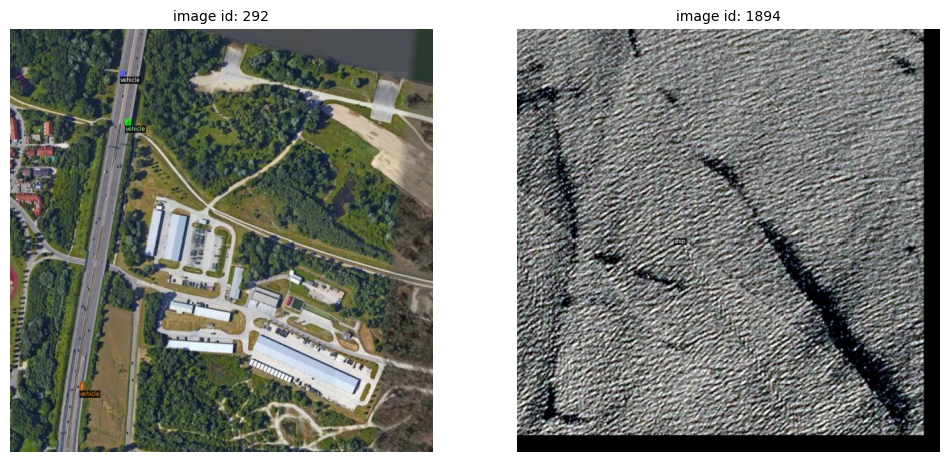

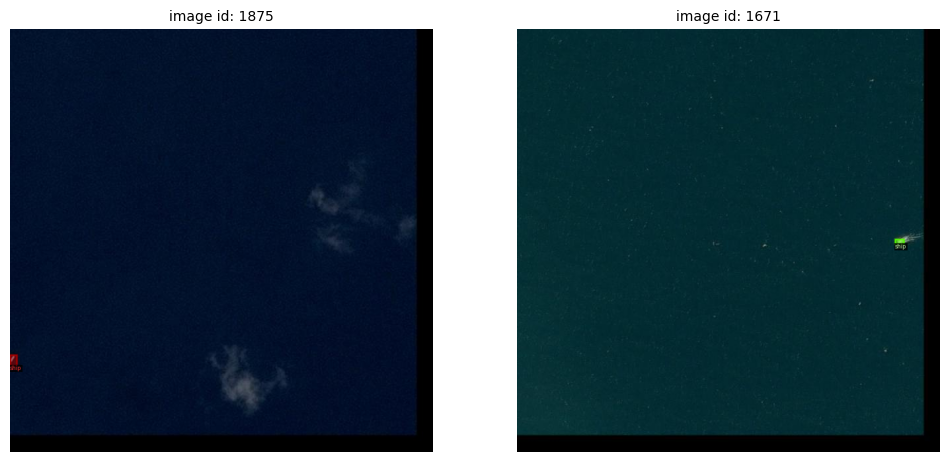

In [8]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5 , image_scale = 1)
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 315 , image_scale = 1)

###**Faster_rcnn_X_101_32x8d_FPN Model, Training**

In [ ]:
from detectron2.engine import DefaultTrainer

EPOCHS = 8000
NUM_CLASSES = 3
BASE_LR = 0.001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("airplane_ship_vehicle_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = "cuda:0"
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR
cfg.SOLVER.MAX_ITER = EPOCHS
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/12 16:19:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:01, 213MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[04/12 16:19:26 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/12 16:19:52 d2.utils.events]:  eta: 2:21:55  iter: 19  total_loss: 3.054  loss_cls: 1.307  loss_box_reg: 0.1611  loss_rpn_cls: 1.206  loss_rpn_loc: 0.236    time: 1.0873  last_time: 0.9076  data_time: 0.0257  last_data_time: 0.0191   lr: 1.9981e-05  max_mem: 5834M
[04/12 16:20:16 d2.utils.events]:  eta: 2:22:24  iter: 39  total_loss: 2.009  loss_cls: 1.028  loss_box_reg: 0.2486  loss_rpn_cls: 0.3078  loss_rpn_loc: 0.2348    time: 1.0694  last_time: 1.0953  data_time: 0.0104  last_data_time: 0.0056   lr: 3.9961e-05  max_mem: 5834M
[04/12 16:20:36 d2.utils.events]:  eta: 2:18:03  iter: 59  total_loss: 1.22  loss_cls: 0.5619  loss_box_reg: 0.1049  loss_rpn_cls: 0.2064  loss_rpn_loc: 0.1637    time: 1.0439  last_time: 1.0872  data_time: 0.0062  last_data_time: 0.0136   lr: 5.9941e-05  max_mem: 5834M
[04/12 16:20:57 d2.utils.events]:  eta: 2:17:52  iter: 79  total_loss: 0.8416  loss_cls: 0.3115  loss_box_reg: 0.151  loss_rpn_cls: 0.1853  loss_rpn_loc: 0.1419    time: 1.0468  last_time: 

In [ ]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

###**Faster_rcnn_X_101_32x8d_FPN validation Results**

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("airplane_ship_vehicle_valid", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "airplane_ship_vehicle_valid")
inference_on_dataset(trainer.model, test_loader, evaluator)

###**Faster_rcnn_X_101_32x8d_FPN Test Results**

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("airplane_ship_vehicle_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "airplane_ship_vehicle_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

###**Faster_rcnn_X_101_32x8d_FPN Test Predictions**

In [ ]:
my_dataset_test_metadata = MetadataCatalog.get("airplane_ship_vehicle_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("airplane_ship_vehicle_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]

    fig, axs = plt.subplots(3,2, figsize = (10,20), dpi = 200)

    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()

        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)

        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)

        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 8)
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)

In [ ]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 3, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 74, image_scale=1)
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 65, image_scale=1)